In [1]:
#standard
import os
import warnings
warnings.filterwarnings('ignore')
import pickle

#third party
import numpy as np
import hcp_utils as hcp
from nilearn import plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


#### This notebook demonstrates how you might perform an intersubject correlation analysis (on beta values, not time series) and use hcp_utils (https://rmldj.github.io/hcp-utils/) to extract data from ROIs is fsLR32k space.

In [2]:
def vectorized_correlation(x,y):
    dim = 0
    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)
    y_std = y.std(axis=dim, keepdims=True)

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

In [3]:
def compute_ISC(betas):
    #computes correlation of beta values between each pair of subjects and averages
    assert(betas.ndim == 3)
    nsub, nstimuli, nvoxels = betas.shape
    assert(nsub == 10)
    corr = np.zeros(nvoxels)
    npairs = 0
    for i in tqdm(range(nsub)):
        for j in range(i+1,nsub):
            corr += vectorized_correlation(betas[i,:,:], betas[j,:,:])
            npairs += 1
    corr = corr/npairs #average
    return corr

In [4]:
#setup paths
dataset_root = "/your/path/to/BOLDMomentsDataset"
fmri_path = os.path.join(dataset_root,"derivatives", "versionB", "fsLR32k","GLM")
subjects = [f"sub-{int(subject):02}" for subject in range(1,11)]

In [5]:
betas_all = np.zeros((len(subjects), 1102, 91282)) #preallocate. This collects all beta values
for count, subject in enumerate(subjects):
    print(f"loading fmri data from subject {subject}")
    with open(os.path.join(fmri_path, subject, "prepared_betas", f"{subject}_organized_betas_task-test_normalized.pkl"), 'rb') as f:
        fmri_data_test, _ = pickle.load(f)
    with open(os.path.join(fmri_path, subject, "prepared_betas", f"{subject}_organized_betas_task-train_normalized.pkl"), 'rb') as f:
        fmri_data_train, _ = pickle.load(f)
    betas_all[count,:,:] = np.vstack((fmri_data_train.mean(axis=1), fmri_data_test.mean(axis=1))) #average betas over repetitions and stack to make a matrix of shape (n_stimuli x n_voxels). train are the first 1000 indices

loading fmri data from subject sub-01
loading fmri data from subject sub-02
loading fmri data from subject sub-03
loading fmri data from subject sub-04
loading fmri data from subject sub-05
loading fmri data from subject sub-06
loading fmri data from subject sub-07
loading fmri data from subject sub-08
loading fmri data from subject sub-09
loading fmri data from subject sub-10


In [6]:
#correlate betas value matrix between each pair of subjects
isc_corr = compute_ISC(betas_all)

100%|██████████| 10/10 [06:18<00:00, 37.85s/it]


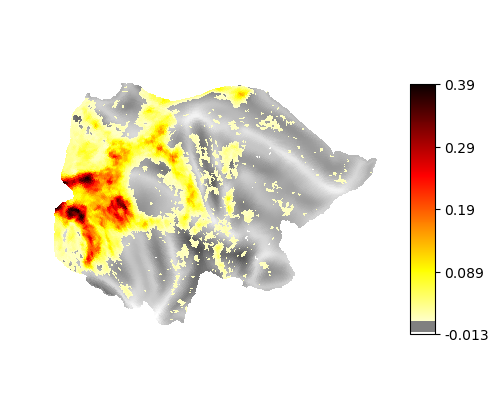

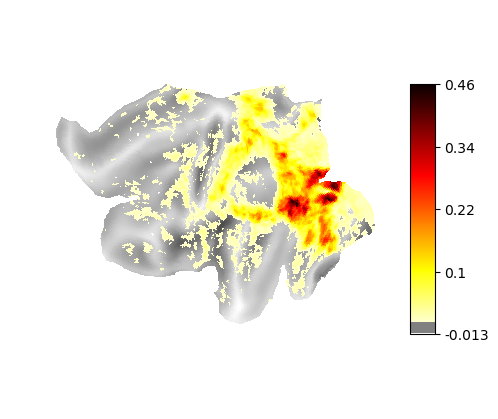

In [7]:
for hemi in ['left','right']:
    #flattened brain
    if hemi == 'left':
        cortex_data = hcp.left_cortex_data(isc_corr)
        display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot_r')
        plt.show()

    if hemi == 'right':
        cortex_data = hcp.right_cortex_data(isc_corr)
        display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot_r')
        plt.show()


In [8]:
#helper function to get hcp ids based on the ROI name
def find_keys_by_value(d, value):
    return [key for key, val in d.items() if val == value]

In [9]:
#now use hcp_utils to look at the average isc in an ROI
# For full table of ROIs and groups, see "Neuroanatomical Supplementary Results" from the Glasser et al., 2016, paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4990127/
# the first four sections represent Primary Visual Cortex, Early Visual Cortex, Dorsal Stream Visual Cortex, and Ventral Stream Visual Cortex, respectively.
hcp_corevision = {
    'Section01': ['V1'], 
    'Section02': ['V2','V3','V4'], 
    'Section03': ['V3A','V3B','V7','V6','V6A','IPS1'], 
    'Section04': ['V8','VVC','VMV1','VMV2','VMV3','PIT','FFC']}
indices = []
for section, rois in hcp_corevision.items():
    for roi in rois:
        for hemi in ['L', 'R']:
            ID = find_keys_by_value(hcp.mmp.labels, f"{hemi}_{roi}")
            assert(len(ID) == 1) #just want exactly one value here
            indices.extend(np.where(hcp.mmp.map_all == ID)[0])

roi_isc = isc_corr[indices]
print(f"mean beta map ISC in your ROIs is {np.nanmean(roi_isc)}")

mean beta map ISC in your ROIs is 0.09638080136177037


In [10]:
#or just specify one or more ROIs
indices = []
for roi in ['MT']:
    for hemi in ['L', 'R']:
        ID = find_keys_by_value(hcp.mmp.labels, f"{hemi}_{roi}")
        assert(len(ID) == 1) #just want exactly one value here
        indices.extend(np.where(hcp.mmp.map_all == ID)[0])

roi_isc = isc_corr[indices]
print(f"mean beta map ISC in your ROI(s) is {np.nanmean(roi_isc)}")

mean beta map ISC in your ROI(s) is 0.30913732335251554
